In [840]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import RFECV #Feature ranking with recursive feature elimination and cross-validated selection of the best number of features.

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error,r2_score

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor


In [841]:
df = pd.read_csv('Hitters.csv')

In [842]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [843]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

# Data Processing

In [844]:
cat_features = ['League','Division','NewLeague'] 
num_features = list(df.select_dtypes(['int64']).columns) # not include 'Salary'

### Missing Values

In [845]:
df.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [846]:
df['New_HitRate']=df["CAtBat"]/df["CHits"]
df['temp'] = pd.cut(df['New_HitRate'],2,labels=[0,1])
df.groupby(['League','temp']).agg({'Salary':'mean'})
df['Salary'] = df['Salary'].fillna(df.groupby(['temp'])['Salary'].transform('mean'))

In [878]:
#df = df.drop('temp',axis=1)
df['temp'] = pd.cut(df['New_HitRate'],2,labels=[0,1])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286 entries, 0 to 321
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   AtBat                  286 non-null    float64 
 1   Hits                   286 non-null    float64 
 2   HmRun                  286 non-null    float64 
 3   Runs                   286 non-null    float64 
 4   RBI                    286 non-null    float64 
 5   Walks                  286 non-null    float64 
 6   Years                  286 non-null    float64 
 7   CAtBat                 286 non-null    float64 
 8   CHits                  286 non-null    float64 
 9   CHmRun                 286 non-null    float64 
 10  CRuns                  286 non-null    float64 
 11  CRBI                   286 non-null    float64 
 12  CWalks                 286 non-null    float64 
 13  PutOuts                286 non-null    float64 
 14  Assists                286 non-null    flo

In [848]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,New_HitRate,temp
0,293,66,1,30,29,14,1,293,66,1,...,14,A,E,446,33,20,537.704225,A,4.439394,"(2.836, 4.92]"
1,315,81,7,24,38,39,14,3449,835,69,...,375,N,W,632,43,10,475.000000,N,4.130539,"(2.836, 4.92]"
2,479,130,18,66,72,76,3,1624,457,63,...,263,A,W,880,82,14,480.000000,A,3.553611,"(2.836, 4.92]"
3,496,141,20,65,78,37,11,5628,1575,225,...,354,N,E,200,11,3,500.000000,N,3.573333,"(2.836, 4.92]"
4,321,87,10,39,42,30,2,396,101,12,...,33,N,E,805,40,4,91.500000,N,3.920792,"(2.836, 4.92]"


In [849]:
pd.cut(df['New_HitRate'],3)

0      (4.227, 5.613]
1      (2.836, 4.227]
2      (2.836, 4.227]
3      (2.836, 4.227]
4      (2.836, 4.227]
            ...      
317    (2.836, 4.227]
318    (2.836, 4.227]
319    (2.836, 4.227]
320    (2.836, 4.227]
321    (2.836, 4.227]
Name: New_HitRate, Length: 322, dtype: category
Categories (3, interval[float64]): [(2.836, 4.227] < (4.227, 5.613] < (5.613, 7.0]]

In [850]:
#df['New_Experience'] = pd.cut(df['Years'],[0,5,10,15,25],labels=[1,2,3,4])
#df.groupby(['League','Division', 'New_Experience']).agg({'Salary':'mean'})
#df['Salary'] = df['Salary'].fillna(df.groupby(['League','Division', 'Experience'])['Salary'].transform('mean'))

In [851]:
#df = df.dropna()

### Outliers

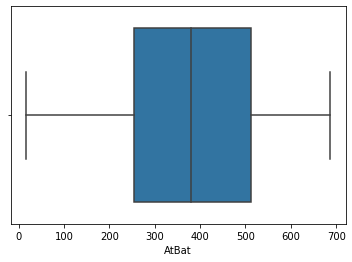

AtBat  : 322


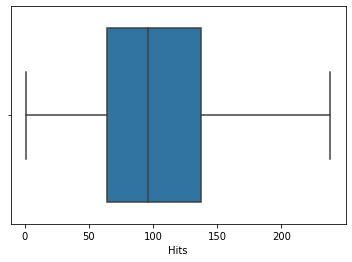

Hits  : 322


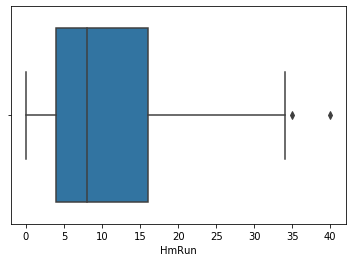

HmRun  : 322


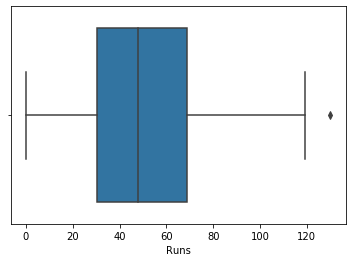

Runs  : 322


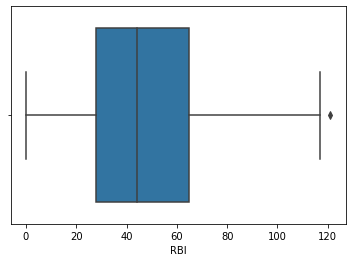

RBI  : 322


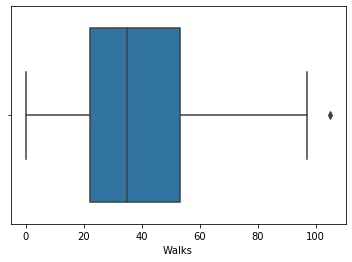

Walks  : 322


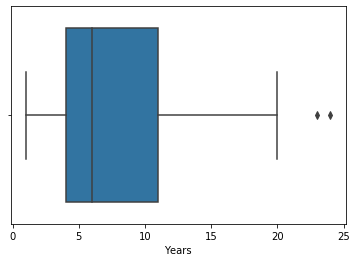

Years  : 322


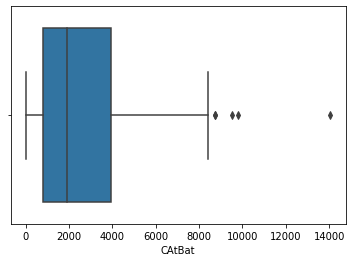

CAtBat  : 322


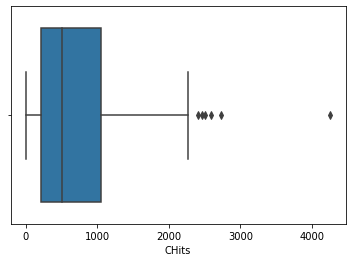

CHits  : 322


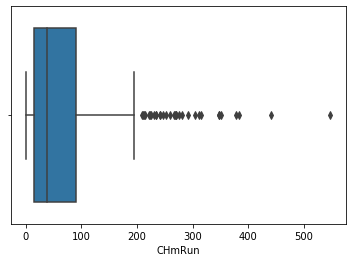

CHmRun  : 322


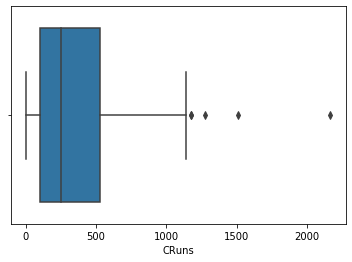

CRuns  : 322


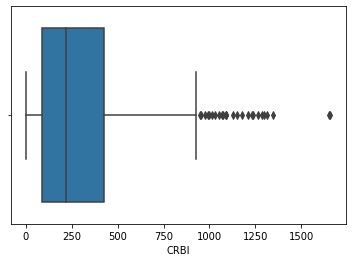

CRBI  : 322


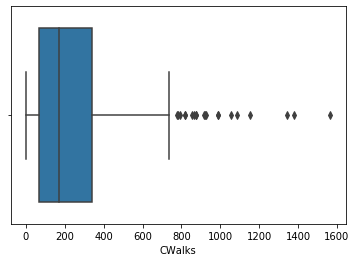

CWalks  : 322


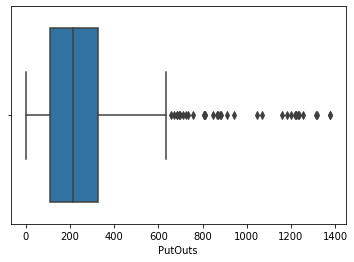

PutOuts  : 322


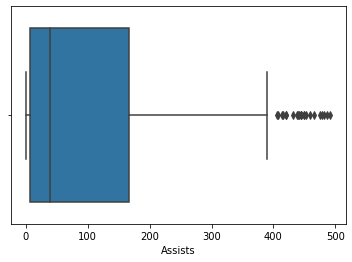

Assists  : 322


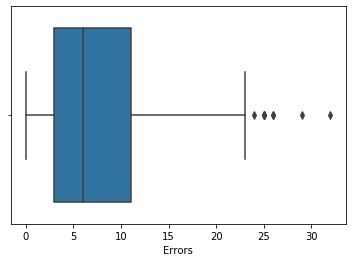

Errors  : 322


In [852]:
num_features = df.select_dtypes(['int64']).columns

for feature in num_features:

    Q1 = df[feature].quantile(0.99)
    Q3 = df[feature].quantile(0.1)
    
    IQR = Q3-Q1
    
    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR
    
    # Visualization of outliers
    
    sns.boxplot(x = df[feature])
    plt.show()

    
    if df[(df[feature] > upper) | (df[feature] < lower)].any(axis=None):
        print(feature," : " + str(df[(df[feature] > upper) | (df[feature] < lower)].shape[0]))
    else:
        print(feature, " : 0")
        
    #Filling outliers with upper or lower limit :
    
    # df[df[feature] < upper][feature] = upper
    ##df[df[feature] > lower][feature] = lower
    
    #Dropping outliers : 
    
    df = df[df[feature]>upper]

In [853]:
#LOF

clf=LocalOutlierFactor(n_neighbors=20, contamination=0.4)
clf.fit_predict(df[num_features])
df_scores=clf.negative_outlier_factor_
df_scores= np.sort(df_scores)
df_scores[0:20]

array([-5.36163264, -2.54779913, -2.54761824, -2.12995308, -2.09374778,
       -2.06309509, -2.03049509, -1.99594485, -1.9876426 , -1.7249404 ,
       -1.63524555, -1.63503538, -1.50421313, -1.49637253, -1.49025551,
       -1.47753864, -1.46874436, -1.45248229, -1.44004493, -1.43654432])

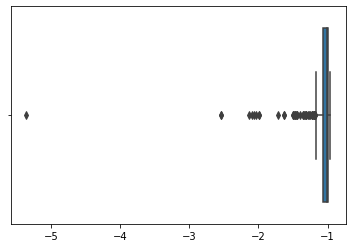

In [854]:
sns.boxplot(df_scores);

In [855]:
threshold=np.sort(df_scores)[1]
print(threshold)
#df = df.loc[df_scores > threshold]
#df = df.reset_index(drop=True)

-2.547799131932263


In [856]:
df.shape

(322, 22)

# Feature Engineering

### Bining Features

In [857]:
df['New_Experience'] = pd.cut(df['Years'],[0,5,10,15,25],labels=[1,2,3,4])

In [858]:
df['New_Experience'].value_counts()

1    142
2     96
3     58
4     26
Name: New_Experience, dtype: int64

In [880]:
cat_features.extend(['New_Experience','temp'])

### Creating New Features

In [860]:
'''
df['New_HitRate']=df["CAtBat"]/df["CHits"] #Sadullah
df['New_ChmrunRate']=df["CHmRun"]/df["CHits"] # Sadullah

df['New_AtBat']=df["CAtBat"]/df["Years"]
df['New_RBI']=df["CRBI"]/df["Years"]
df['New_Walks']=df["CWalks"]/df["Years"]
df['New_Hits']=df["CHits"]/df["Years"]
df['New_HmRun']=df["CHmRun"]/df["Years"]
df['New_Runs']=df["CRuns"]/df["Years"]

df['New_CatBat_CRuns_Rate']=df["CAtBat"]/df["CRuns"] #AbdulKadir
df['New_Hits_Assist_Rate']=df["Hits"]/df["Assists"] # AbdulKadir
'''

'\ndf[\'New_HitRate\']=df["CAtBat"]/df["CHits"] #Sadullah\ndf[\'New_ChmrunRate\']=df["CHmRun"]/df["CHits"] # Sadullah\n\ndf[\'New_AtBat\']=df["CAtBat"]/df["Years"]\ndf[\'New_RBI\']=df["CRBI"]/df["Years"]\ndf[\'New_Walks\']=df["CWalks"]/df["Years"]\ndf[\'New_Hits\']=df["CHits"]/df["Years"]\ndf[\'New_HmRun\']=df["CHmRun"]/df["Years"]\ndf[\'New_Runs\']=df["CRuns"]/df["Years"]\n\ndf[\'New_CatBat_CRuns_Rate\']=df["CAtBat"]/df["CRuns"] #AbdulKadir\ndf[\'New_Hits_Assist_Rate\']=df["Hits"]/df["Assists"] # AbdulKadir\n'

In [861]:
df['New_HitRate']=df["CAtBat"]/df["CHits"]
df['New_ChmrunRate']=df["CHmRun"]/df["CHits"]

df['New_AtBat']=df["CAtBat"]/df["AtBat"]
df['New_RBI']=df["CRBI"]/df["RBI"]
df['New_Walks']=df["CWalks"]/df["Walks"]
df['New_Hits']=df["CHits"]/df["Hits"]
df['New_HmRun']=df["CHmRun"]/df["HmRun"]
df['New_Runs']=df["CRuns"]/df["Runs"]

df['New_CatBat_CRuns_Rate']=df["CAtBat"]/df["CRuns"] #AbdulKadir
df['New_Hits_Assist_Rate']=df["Hits"]/df["Assists"] # AbdulKadir

In [862]:
num_features = list(df.select_dtypes(['int64','float64']).columns)
num_features.remove('Salary')

In [863]:
len(num_features)

26

In [864]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322 entries, 0 to 321
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   AtBat                  322 non-null    int64   
 1   Hits                   322 non-null    int64   
 2   HmRun                  322 non-null    int64   
 3   Runs                   322 non-null    int64   
 4   RBI                    322 non-null    int64   
 5   Walks                  322 non-null    int64   
 6   Years                  322 non-null    int64   
 7   CAtBat                 322 non-null    int64   
 8   CHits                  322 non-null    int64   
 9   CHmRun                 322 non-null    int64   
 10  CRuns                  322 non-null    int64   
 11  CRBI                   322 non-null    int64   
 12  CWalks                 322 non-null    int64   
 13  League                 322 non-null    object  
 14  Division               322 non-null    obj

### Feature Transformation(categorical features)

In [881]:
df = pd.get_dummies(df, columns = cat_features, drop_first = True)

KeyError: "['League', 'Division', 'New_Experience', 'NewLeague'] not in index"

In [883]:
df = pd.get_dummies(df, columns = ['temp'], drop_first = True)

### Feature Scaling(Continuous Variables)

In [866]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [867]:
std_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

df[num_features] = min_max_scaler.fit_transform(df[num_features])

### Feature Selecting

In [885]:
y = df["Salary"]
X = df.drop('Salary', axis=1)

In [869]:
def select_features(X,y):
    # numerik olmayan degiskenlerin silinmesi
    X = X.select_dtypes([np.number]).dropna(axis=1)
    
    clf = LGBMRegressor()
    clf.fit(X, y)
    
    selector = RFECV(clf,cv=10)
    selector.fit(X, y)
    
    features = pd.DataFrame()
    features['Feature'] = X.columns
    features['Importance'] = clf.feature_importances_
    features.sort_values(by=['Importance'], ascending=False, inplace=True)
    features.set_index('Feature', inplace=True)
    features.plot(kind='bar', figsize=(12, 5))
    
    
    best_columns = list(X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

In [870]:
best_features = select_features(X,y)
best_features

KeyboardInterrupt: 

In [650]:
#X= X[['New_ChmrunRate','New_Hits_Assist_Rate','CRBI','New_HitRate','Years','New_CatBat_CRuns_Rate','CWalks','Walks','PutOuts']]
#X = X[best_features]
X.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,New_Walks,New_Hits,New_HmRun,New_Runs,New_CatBat_CRuns_Rate,New_Hits_Assist_Rate,League_N,Division_W,NewLeague_N,"temp_(4.92, 7.0]"
0,0.410180,0.264957,0.000000,0.218750,0.226891,0.125000,0.000000,0.028077,0.022727,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.412027,0.020904,0,0,0,0
1,0.443114,0.329060,0.153846,0.171875,0.302521,0.365385,0.590909,0.351470,0.304619,0.154195,...,0.107245,0.125686,0.046987,0.137719,0.489377,0.019653,1,1,1,0
2,0.688623,0.538462,0.435897,0.500000,0.588235,0.721154,0.090909,0.164464,0.166056,0.140590,...,0.030629,0.033963,0.013263,0.026642,0.212960,0.016443,0,1,0,0
3,0.714072,0.585470,0.487179,0.492188,0.638655,0.346154,0.454545,0.574752,0.575880,0.507937,...,0.106650,0.137319,0.054377,0.130635,0.177136,0.137300,1,0,1,0
4,0.452096,0.354701,0.230769,0.289062,0.336134,0.278846,0.045455,0.038631,0.035557,0.024943,...,0.001245,0.002173,0.001061,0.002568,0.292060,0.022787,1,0,1,0


# Modelling

In [876]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286 entries, 0 to 321
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   AtBat                  286 non-null    float64 
 1   Hits                   286 non-null    float64 
 2   HmRun                  286 non-null    float64 
 3   Runs                   286 non-null    float64 
 4   RBI                    286 non-null    float64 
 5   Walks                  286 non-null    float64 
 6   Years                  286 non-null    float64 
 7   CAtBat                 286 non-null    float64 
 8   CHits                  286 non-null    float64 
 9   CHmRun                 286 non-null    float64 
 10  CRuns                  286 non-null    float64 
 11  CRBI                   286 non-null    float64 
 12  CWalks                 286 non-null    float64 
 13  PutOuts                286 non-null    float64 
 14  Assists                286 non-null    flo

In [886]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,random_state=46)

### LightGBM

In [887]:
lgbm_model = LGBMRegressor().fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)

In [839]:
lgbm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lgbm_rmse

304.35291472486415

In [803]:
lgbm_cv_rmse =  np.sqrt(np.mean(-cross_val_score(lgbm_model, X_train, y_train, cv = 10, scoring = "neg_mean_squared_error")))
lgbm_cv_rmse 

274.9094768257062

In [804]:
np.sqrt(-cross_val_score(lgbm_model, X_train, y_train, cv = 10, scoring = "neg_mean_squared_error"))

array([190.5871668 , 281.8676176 , 377.38733118, 299.1960428 ,
       432.99503923, 183.89432724, 231.65736649, 240.62370651,
       234.22940311, 142.51234426])

In [623]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286 entries, 0 to 321
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   AtBat                  286 non-null    float64 
 1   Hits                   286 non-null    float64 
 2   HmRun                  286 non-null    float64 
 3   Runs                   286 non-null    float64 
 4   RBI                    286 non-null    float64 
 5   Walks                  286 non-null    float64 
 6   Years                  286 non-null    float64 
 7   CAtBat                 286 non-null    float64 
 8   CHits                  286 non-null    float64 
 9   CHmRun                 286 non-null    float64 
 10  CRuns                  286 non-null    float64 
 11  CRBI                   286 non-null    float64 
 12  CWalks                 286 non-null    float64 
 13  PutOuts                286 non-null    float64 
 14  Assists                286 non-null    flo

### LightGBM Tuning

In [109]:
lgbm_params = {"learning_rate": [0.01,0.001, 0.1, 0.5, 1],
              "n_estimators": [200,500,1000,5000],
              "max_depth": [2,4,6,7,10],
              "colsample_bytree": [1,0.8,0.5,0.4]}
lgbm_model = LGBMRegressor()
lgbm_gridcv_model = GridSearchCV(estimator=lgbm_model, param_grid=lgbm_params, cv=10, n_jobs=-1, verbose=2).fit(X_train,y_train)
lgbm_gridcv_model.best_params_

NameError: name 'LGBMRegressor' is not defined

In [ ]:
lgbm_tuned_model = ElasticNet(**lgbm_gridcv_model.best_params_)

In [ ]:
lgbm_tuned_model.fit(X_train, y_train)
y_pred = lgbm_tuned_model.predict(X_test)

In [ ]:
lgbm_tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lgbm_tuned_rmse

In [ ]:
lgbm_tuned_cv_rmse =  np.sqrt(np.mean(-cross_val_score(lgbm_tuned_model, X_train, y_train, cv = 10, scoring = "neg_mean_squared_error")))
lgbm_tuned_cv_rmse 